In [1]:
# -*- coding: utf-8 -*-
"""resnet34b8.ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/1a36A4nIJxIXOauEuScVyFfoA-sPmesKW
"""

!curl https://course.fast.ai/setup/colab | bash

import os
import gc
import re

import cv2
import math
import numpy as np
import scipy as sp
import pandas as pd

import tensorflow as tf

from keras.utils import plot_model
import tensorflow.keras.layers as L
from keras.utils import model_to_dot
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model

from tensorflow.keras.applications import InceptionResNetV2,ResNet50

import seaborn as sns
from tqdm import tqdm
import matplotlib.cm as cm
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

tqdm.pandas()
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

np.random.seed(0)
tf.random.set_seed(0)

import warnings
warnings.filterwarnings("ignore")

# Load the Drive helper and mount
from google.colab import drive


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  9127    0  9127    0     0  51857      0 --:--:-- --:--:-bash: line 1: syntax error near unexpected token `newline'
-bash: line 1: `<!DOCTYPE html>'
 --:--:-- 51857


In [2]:
# This will prompt for authorization.
drive.mount('/content/drive')

from zipfile import ZipFile 
def unZip(file_name):
  with ZipFile(file_name, 'r') as zip: 
      zip.extractall() 
      print('Done!')

unZip('drive/My Drive/Research/dataset_tb.zip')



!ls dataset

Mounted at /content/drive
Done!
0  1


In [3]:
import glob
filesN= sorted(glob.glob('dataset/0/*.png'))
filesP= sorted(glob.glob('dataset/1/*.png'))

filesN,filesP

pos_labels=[[i,1] for i in filesP]
neg_labels=[[i,0] for i in filesN]
ds=pos_labels+neg_labels

np.random.seed(4200)

In [4]:
import pandas as pd 
df = pd.DataFrame(ds,columns =['path', 'label']) 
def Randomizing(df):
    df2 = df.reindex(np.random.permutation(df.index))
    return df2
df=Randomizing(df)

from sklearn.model_selection import train_test_split
dfTrain,dfTest=train_test_split(df, shuffle=False,test_size=0.2, random_state=42)

In [5]:
from fastai.vision import *
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

bs =8
sz=224
tfms = get_transforms(do_flip=True,flip_vert=True,max_lighting=0.4,max_zoom=1.1)
src = (ImageList.from_df(df=dfTrain,path='',cols='path') #get dataset from dataset
        .split_by_rand_pct(0.2) #Splitting the dataset
        .label_from_df(cols='label') #obtain labels from the level column
      )
data= (src.transform(tfms,size=224,padding_mode='zeros') #Data augmentation
        .databunch(bs=bs,num_workers=4) #DataBunch
        .normalize(imagenet_stats) #Normalize     
       )

# from sklearn.metrics import roc_auc_score,f1_score
# def f1_score_a(y_pred,y_true,tens=True):
# #     score=roc_auc_score(y_true,torch.sigmoid(y_pred)[:,1])
#     f1a_score=f1_score(y_true, np.round(torch.sigmoid(y_pred)[:,1]), average='macro') 
#     if tens:
# #         score=tensor(score)
#         f1a_score=tensor(f1a_score)
#     else:
#         f1a_score=f1a_score
#     return f1a_score

In [6]:
import torch 
import torchvision
import torch.nn as nn
model = torchvision.models.resnet34(pretrained=True)



num_ftrs = model.fc.in_features
model.fc=nn.Sequential(nn.Dropout(0.3),nn.Linear(num_ftrs,2))

import pickle
model=model.cuda()
filename = 'finalized_model.sav'
pickle.dump(model, open(filename, 'wb'))

from fastai.callbacks import *

learn = Learner(data, model, metrics=[error_rate, accuracy])

from fastai.callbacks import *
learn.fit(60,lr=0.00001)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.763186,0.739718,0.419048,0.580952,01:26
1,0.665419,0.585113,0.257143,0.742857,01:16
2,0.603685,0.534540,0.257143,0.742857,01:15
3,0.550789,0.541244,0.247619,0.752381,01:15
4,0.503080,0.536306,0.219048,0.780952,01:19
5,0.485785,0.651381,0.238095,0.761905,01:17
6,0.504432,0.507061,0.238095,0.761905,01:15
7,0.510723,0.503128,0.228571,0.771429,01:15
8,0.478588,0.525150,0.295238,0.704762,01:16
9,0.440164,0.510697,0.257143,0.742857,01:16


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.220074,0.529131,0.152381,0.847619,01:16
1,0.247938,0.473938,0.133333,0.866667,01:16
2,0.244050,0.485375,0.152381,0.847619,01:15
3,0.222266,0.489579,0.171429,0.828571,01:15
4,0.250038,0.480624,0.161905,0.838095,01:15
5,0.230264,0.537382,0.161905,0.838095,01:16
6,0.249444,0.491202,0.123810,0.876190,01:15
7,0.225035,0.582102,0.171429,0.828571,01:16
8,0.269077,0.593514,0.161905,0.838095,01:15
9,0.224675,0.592725,0.171429,0.828571,01:15


TypeError: ignored

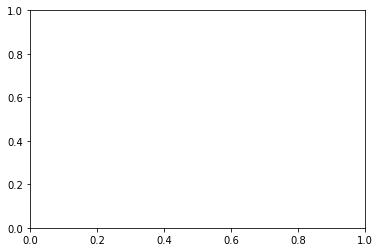

In [7]:
learn.unfreeze()

learn.fit(60,lr=0.00001)
import numpy as np




In [9]:
bs =8
sz=224
tfms = get_transforms(do_flip=True,flip_vert=True,max_lighting=0.4,max_zoom=1.1)
src = (ImageList.from_df(df=dfTest,path='',cols='path') #get dataset from dataset
        .split_by_rand_pct(0.0) #Splitting the dataset
        .label_from_df(cols='label') #obtain labels from the level column
      )
data= (src.transform(tfms,size=224,padding_mode='zeros') #Data augmentation
        .databunch(bs=bs,num_workers=4) #DataBunch
        .normalize(imagenet_stats) #Normalize     
       )

learn.data.valid_dl = data.train_dl


Precision of Model = 0.8307692307692308 Recall of Model  0.9
F1 Score of Model = 0.8640000000000001


The accuracy is 0.8828125 %.
ROC area is 0.9261071690726694


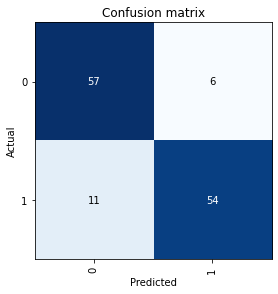

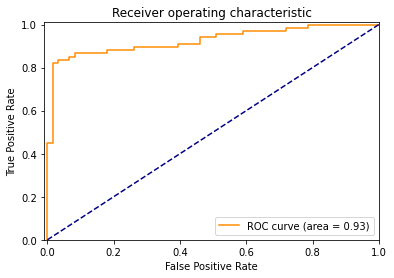

In [10]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()
conf=interp.confusion_matrix()
TrueNagitive=conf[0][0]
FalseNegative=conf[0][1]
TruePositive=conf[1][1]
FalsePositive=conf[1][0]
recal=TruePositive/(TruePositive+FalseNegative)
precision=TruePositive/(TruePositive+FalsePositive)
print("Precision of Model =",precision,"Recall of Model ", recal)
f1=2*((precision*recal)/(precision+recal))
print('F1 Score of Model =',f1)

preds,y, loss = learn.get_preds(with_loss=True)
acc = accuracy(preds, y)
print('The accuracy is {0} %.'.format(acc))
from sklearn.metrics import roc_curve, auc
# probs from log preds
probs = np.exp(preds[:,1])
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y, probs, pos_label=1)

# Compute ROC area
roc_auc = auc(fpr, tpr)
print('ROC area is {0}'.format(roc_auc))
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

TypeError: ignored

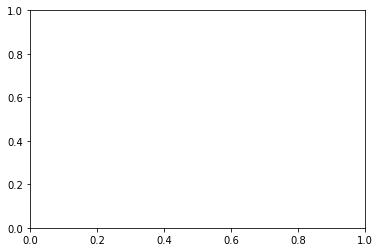

In [11]:
import matplotlib.pyplot as plot
plot.plot(error_rate, accuracy)